In [65]:
from itertools import product

import graspologic as gp
import matplotlib.pyplot as plt
import numpy as np
from graspologic.embed import AdjacencySpectralEmbed, OmnibusEmbed
from graspologic.plot import heatmap
from graspologic.simulations import p_from_latent, sample_edges
from joblib import Parallel, delayed

from pkg.inference.vertex_position_test import *
from pkg.inference.vertex_position_test import _bootstrap, _difference_norm, _embed

In [3]:
def compute_delta(p, eps):
    delta = ((p + eps) ** 2 - p**2) / p

    return delta


def sample_latent(n, p, eps, seed=None):
    ps = np.repeat(p, n).reshape(-1, 1)
    X = np.sqrt(ps)

    delta = compute_delta(p, eps)
    delta_vec = np.zeros((n, 1))
    delta_vec[0, 0] += delta

    Y = np.sqrt(ps + delta_vec)

    return X, Y


def sample_graphs(n, p, eps, seed=None):
    X, Y = sample_latent(n=n, p=p, eps=eps, seed=seed)

    P_X = gp.simulations.p_from_latent(X)
    P_Y = gp.simulations.p_from_latent(Y)

    np.random.seed(seed)
    A = gp.simulations.sample_edges(P_X)
    B = gp.simulations.sample_edges(P_Y)

    return A, B

In [74]:
def experiment(n, p, eps, test_case='rotation', alpha=0.05, n_reps=500, n_jobs=-1):
    def worker(seed):
        A, B = sample_graphs(n, p, eps, seed)
        _, pval, _, _ = vertex_position_test(A, B, n_components=2,test_case=test_case, n_bootstraps=500)  # rank 2 p matrix

        return pval.reshape(-1, 1)

    res = Parallel(n_jobs=n_jobs)(delayed(worker)(seed) for seed in range(n_reps))
    pvals = np.hstack(res)

    return pvals

In [75]:
n = 100
p = 0.25
eps = np.linspace(0, 0.75, 16)
test_cases = ["rotation", "scalar-rotation", "diagonal-rotation"]
n_reps = 500

args = [dict(n=n, p=p, test_case=t, eps=e) for t, e in product(test_cases, eps)]

In [ ]:
res = []

for arg in args:
    # print(f"Running args: {arg}")
    res.append(experiment(**arg))

In [39]:
power = [(r <= 0.05).mean(axis=1) for r in res]

[Text(0.5, 0, 'Effect size'), Text(0.5, 1.0, 'Vertex of Interest')]

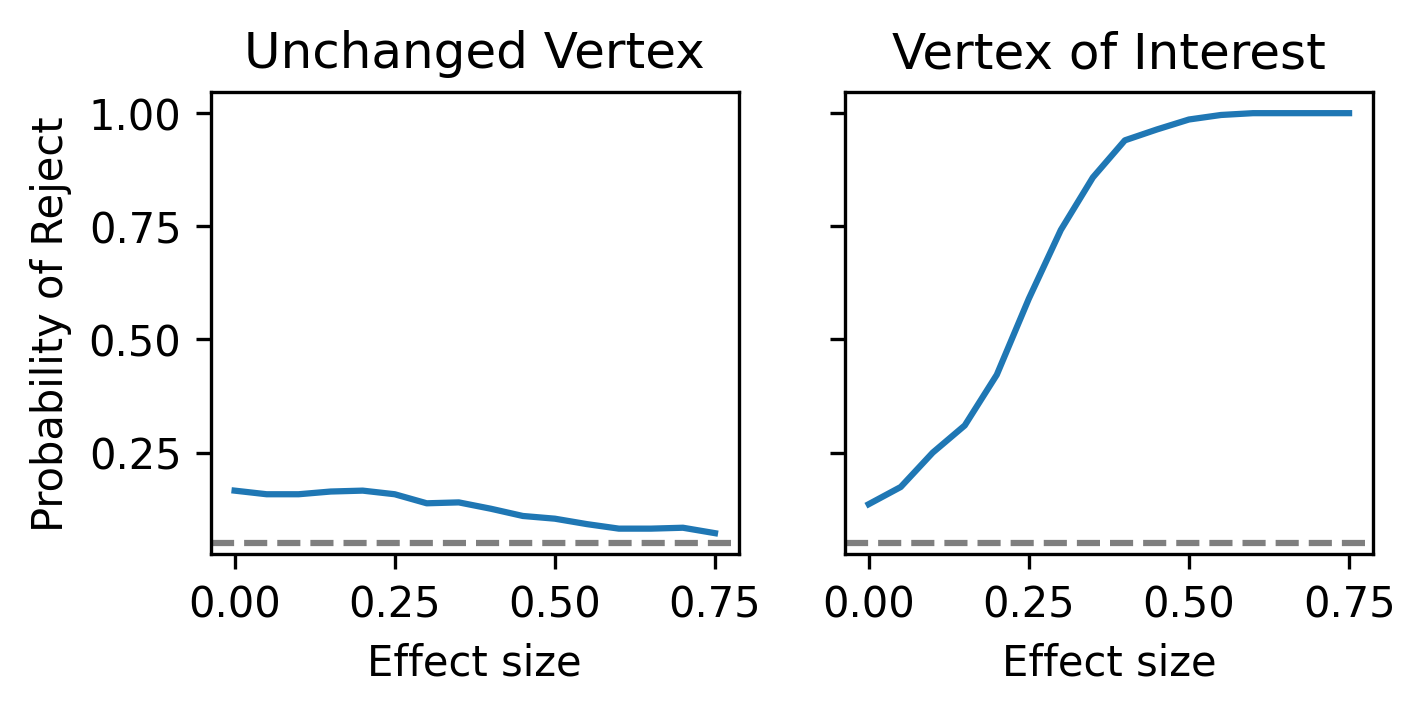

In [64]:
vertex_changed = [p[0] for p in power]
vertex_control = [p[1] for p in power]

fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True,figsize=(5, 2), dpi=300)

ax[0].plot(eps, vertex_control)
ax[1].plot(eps, vertex_changed)

ax[0].axhline(0.05, ls='--', alpha=0.5, c='k')
ax[1].axhline(0.05, ls='--', alpha=0.5, c='k')

ax[0].set(ylabel="Probability of Reject", xlabel="Effect size", title="Unchanged Vertex")
ax[1].set(xlabel="Effect size", title="Vertex of Interest")